In [1]:
import pandas as pd
from glob import glob
import numpy as np
from tqdm import tqdm
import requests
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from model_training_process import get_cnn_model
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices("GPU")
print(f"tf.config.list_physical_devices('GPU'): {tf.config.list_physical_devices('GPU')}")

tf.config.list_physical_devices('GPU'): []


In [2]:
class_df = pd.read_csv(filepath_or_buffer="..\\tables\\corrected_class_df_pinyin_label_table.csv")
class_df

,bopomofo,pinyin,hu_yin,she2_yin,hu_yin_label,she2_yin_label,class_label
0,ㄓ,zhi,純聲符,翹舌音,0,5,0
1,ㄔ,chi,純聲符,翹舌音,0,5,0
2,ㄕ,shi,純聲符,翹舌音,0,5,0
3,ㄖ,ri,純聲符,翹舌音,0,5,0
4,ㄗ,zi,純聲符,平舌音,0,6,1
...,...,...,...,...,...,...,...
402,ㄒㄩㄣ,xun,撮口呼,舌面音,4,4,20
403,ㄩㄥ,yong,撮口呼,純韻符,4,0,18
404,ㄐㄩㄥ,jiong,撮口呼,舌面音,4,4,20
405,ㄑㄩㄥ,qiong,撮口呼,舌面音,4,4,20


In [3]:
npy_file_path = glob("..\\..\\data\\*EduVer\\*.npy", recursive=True)
print(f"len(npy_file_path) = {len(npy_file_path)}")

len(npy_file_path) = 67173


In [4]:
npy_file_path_selected = list()
for npy_file in npy_file_path:
    pinyin = npy_file.split("_")[1]
    pinyin_non_accent = pinyin[:-1] if pinyin[-1].isdigit() else pinyin
    if pinyin_non_accent in list(class_df["pinyin"]):
        npy_file_path_selected.append(npy_file)
print(f"len(npy_file_path_selected) = {len(npy_file_path_selected)}")

len(npy_file_path_selected) = 66852


In [5]:
data_class_label = list()
for npy_file in tqdm(npy_file_path_selected):
    pinyin = npy_file.split("_")[1]
    pinyin_non_accent = pinyin[:-1] if pinyin[-1].isdigit() else pinyin
    class_label = class_df.loc[class_df["pinyin"] == pinyin_non_accent, "class_label"].iloc[0]
    data_class_label.append(class_label)
data_class_label = np.array(data_class_label)
print(f"len(data_class_label) = {len(data_class_label)}")

100%|██████████| 66852/66852 [00:13<00:00, 4879.50it/s]

len(data_class_label) = 66852


In [6]:
mfcc_matrix_list = list()
for npy_file in tqdm(npy_file_path_selected):
    mfcc_matrix = np.load(npy_file)
    mfcc_matrix_list.append(mfcc_matrix)
mfcc_matrix_list = np.array(mfcc_matrix_list)
print(f"len(mfcc_matrix_list) = {len(mfcc_matrix_list)}")

 38%|███▊      | 25276/66852 [02:36<04:18, 161.11it/s]


KeyboardInterrupt: 

In [53]:
scaler = StandardScaler()
# 因為標準器只能fit 2維的資料所以要將3維的mfcc資料集reshape成2維
# mfcc_data_nums: k
# mfcc_row: n
# mfcc_column: m
# (k, n, m) => (k * n, m)
scaler.fit(mfcc_matrix_list.reshape((mfcc_matrix_list.shape[0] * mfcc_matrix_list.shape[1], mfcc_matrix_list.shape[2])))

mfcc_matrix_list_scaled = []
for mfcc in mfcc_matrix_list:
    mfcc_matrix_list_scaled.append(scaler.transform(mfcc))

# 將list()轉換成np.array()
mfcc_matrix_list_scaled = np.array(mfcc_matrix_list_scaled)

print(f"type(mfcc_matrix_list_scaled): {type(mfcc_matrix_list_scaled)}")
print(f"mfcc_matrix_list_scaled.shape: {mfcc_matrix_list_scaled.shape}")

# 不要印出 ipynb會爆炸
# mfcc_matrix_list_scaled

type(mfcc_matrix_list_scaled): <class 'numpy.ndarray'>
mfcc_matrix_list_scaled.shape: (66852, 13, 44)


In [51]:
best_params = json.load(open(f"..\\..\\grid_search\\method1_with_fake_data\\best_params.json", "r"))

learning_rate = best_params["learning_rate"]
num_filters = best_params["num_filters"]
dense_units = best_params["dense_unit"]
batch_size = best_params["batch_size"]
epochs = best_params["epochs"]

In [52]:
channel = 1
verbose = 2
num_classes = len(class_df.index)
test_size = 0.2
mfcc_dim_1 = mfcc_matrix_list.shape[1]
mfcc_dim_2 = mfcc_matrix_list.shape[2]
print(f"mfcc_dim_1: {mfcc_dim_1}")
print(f"mfcc_dim_2: {mfcc_dim_2}")

mfcc_dim_1: 13
mfcc_dim_2: 44


In [54]:
X = mfcc_matrix_list_scaled
y = data_class_label

# 將int label轉換成二進制one hot標籤
y_one_hot = to_categorical(y, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=test_size, random_state=42)

X_train = X_train.reshape(X_train.shape[0], mfcc_dim_1, mfcc_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], mfcc_dim_1, mfcc_dim_2, channel)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

In [56]:
model = get_cnn_model(input_shape=(mfcc_dim_1, mfcc_dim_2, channel), num_classes=num_classes, learning_rate=learning_rate, num_filters=num_filters, dense_units=dense_units)
model_train_info = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test))

Epoch 1/300
418/418 - 11s - loss: 2.2467 - accuracy: 0.3509 - val_loss: 2.3653 - val_accuracy: 0.3179 - 11s/epoch - 26ms/step
Epoch 2/300
418/418 - 8s - loss: 1.6153 - accuracy: 0.4803 - val_loss: 1.7769 - val_accuracy: 0.4315 - 8s/epoch - 20ms/step
Epoch 3/300
418/418 - 8s - loss: 1.4771 - accuracy: 0.5279 - val_loss: 1.5342 - val_accuracy: 0.5101 - 8s/epoch - 20ms/step
Epoch 4/300
418/418 - 9s - loss: 1.2922 - accuracy: 0.5975 - val_loss: 1.9479 - val_accuracy: 0.4313 - 9s/epoch - 20ms/step
Epoch 5/300
418/418 - 8s - loss: 0.5368 - accuracy: 0.8402 - val_loss: 0.7572 - val_accuracy: 0.7578 - 8s/epoch - 20ms/step
Epoch 6/300
418/418 - 8s - loss: 0.3576 - accuracy: 0.8848 - val_loss: 0.7856 - val_accuracy: 0.7662 - 8s/epoch - 20ms/step
Epoch 7/300
418/418 - 8s - loss: 0.2944 - accuracy: 0.9035 - val_loss: 0.8401 - val_accuracy: 0.7394 - 8s/epoch - 20ms/step
Epoch 8/300
418/418 - 8s - loss: 0.2401 - accuracy: 0.9206 - val_loss: 0.8894 - val_accuracy: 0.7112 - 8s/epoch - 19ms/step
Epoch 

In [57]:
# DISCORD -> 設定 -> 整合 -> Webhook -> 新 Webhook > -> 複製 Webhook 網址
DISCORD_WEBHOOK_URL = "https://discord.com/api/webhooks/1287413088970346557/30gx7NdIfSxS1BRWk28IRkOHJeoET-ihIN_KAjYeXYkrpPeI0hBnE-68AHzhpTR4h3et"
requests.post(
    url=DISCORD_WEBHOOK_URL,
    data={"content": "cnn with fake data模型訓練已完成!"}
)

<Response [204]>

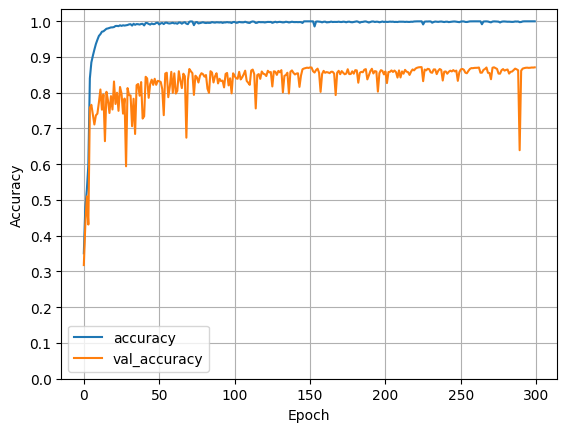

In [58]:
accuracies = model_train_info.history['accuracy']
val_accuracies = model_train_info.history['val_accuracy']

plt.plot(list(range(epochs)), accuracies, label = 'accuracy')
plt.plot(list(range(epochs)), val_accuracies, label = 'val_accuracy')
plt.legend()
plt.grid()
plt.xticks(ticks = list(range(1, epochs + 1))) 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(ticks=list(range(0, epochs + 1, 50)))
plt.yticks(ticks=list(np.arange(0, 1 + 0.1, 0.1)))
plt.show()

In [59]:
print(f"資料: {mfcc_matrix_list_scaled.shape}")
print(f"最高準確率: {max(val_accuracies)}")

資料: (66852, 13, 44)
最高準確率: 0.8715877532958984


In [60]:
model.save(f".\\cnn_layer1_with_fake_model.h5")